This code was run on google collab. This is just the downloaded file

Link to google collaboratory is given below
https://colab.research.google.com/drive/1HhEJiovuMoocqCDrelsVbKCCyVIvkJNR?usp=sharing


In [1]:
!pip install jovian --upgrade --quiet

## Downloading the dataset from Kaggle
1. Made a dataset including images of 8 anime characters.
2. Approximately 100 images for each anime character.
4. Uploaded the dataset on Kaggle.
5. Downloding the Dataset from Kaggle using the opendatasets library.
6. Link for the dataset : https://www.kaggle.com/datasets/abhimanyugautam/finalmaybe


In [2]:
!pip install opendatasets --upgrade --quiet  # Library for downloading dataset

In [3]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/abhimanyugautam/finalmaybe'

In [5]:
od.download(dataset_url)   ## downloading dataset from kaggle

Skipping, found downloaded files in "./finalmaybe" (use force=True to force download)


In [6]:
data_dir = './finalmaybe/Reality'

In [7]:
import os

In [8]:
os.listdir(data_dir) 

['Tohsaka Rin',
 'Asuka Langley Soryu',
 'Kurumi Tokisaki',
 'Rei Ayanami',
 'Chitoge Kirisaki',
 'Tobichi Origami',
 'Kosaki Onodera',
 'Saber Fate']

## Importing the Dataset into pytorch.
###Pytorch: A machine learning library.


###Torchvision: Another library which goes along with Pytorch, used for computer vision and image transformations.

In [9]:
from torchvision.datasets import ImageFolder 

In [10]:
dataset = ImageFolder(data_dir)

In [11]:
dataset.classes

['Asuka Langley Soryu',
 'Chitoge Kirisaki',
 'Kosaki Onodera',
 'Kurumi Tokisaki',
 'Rei Ayanami',
 'Saber Fate',
 'Tobichi Origami',
 'Tohsaka Rin']

In [12]:
for cls in os.listdir(data_dir):  
  print(cls, ":", len(os.listdir(data_dir+ "/" +cls)))

Tohsaka Rin : 193
Asuka Langley Soryu : 98
Kurumi Tokisaki : 67
Rei Ayanami : 122
Chitoge Kirisaki : 101
Tobichi Origami : 99
Kosaki Onodera : 172
Saber Fate : 91


In [13]:
len(dataset) 

943

In [14]:
dataset[0]  ## Its a PIL image (Python imaging Library)

(<PIL.Image.Image image mode=RGB size=259x194 at 0x7F0B19848A50>, 0)

In [15]:
import matplotlib.pyplot as plt  #checking the image using matplotlib
%matplotlib inline

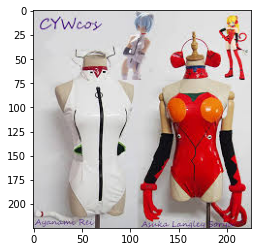

In [16]:
img,label = dataset[77]
plt.imshow(img)

### Resizing images to the same dimensions and converting the images to tensors from PIL(python Imaging Library) images.

* Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width

* A PyTorch Tensor is basically the same as a numpy array

In [17]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),tt.RandomCrop(64),tt.ToTensor()]))

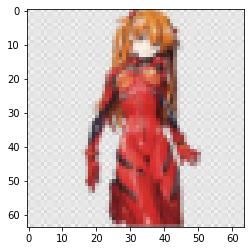

In [18]:
img,label = dataset[5]     # Displaying tensor image
plt.imshow(img.permute(1,2,0))

### Splitting the Dataset to training and validation dataset.

In [19]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))
train_size = len(dataset) - val_size

train_size, val_size 

(849, 94)

In [20]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(849, 94)

### Using the DataLoader to load the data in batches.

In [21]:
from torch.utils.data import DataLoader

batch_size = 4  # Setting a batch size

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
from torchvision.utils import make_grid

def show_batch(dl):                              
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


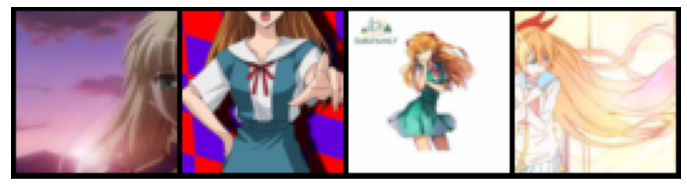

In [23]:
show_batch(train_dl)   # A batch of data

## GPU Utility Functions and Classes

In [24]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
torch.cuda.is_available() #Checking if a GPU is available

True

In [26]:
device = get_default_device()

In [27]:
device # cuda : A language to communicate with the GPU

device(type='cuda')

#### Moving a single image onto the GPU (testing)

In [28]:
img,label = dataset[0]

In [29]:
img.shape

torch.Size([3, 64, 64])

In [30]:
img.device

device(type='cpu')

In [31]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

#### Moving all the data onto the GPU using the DeviceDataLoader class.

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilities

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generates predictions
        loss = F.cross_entropy(out, labels) # Calculates loss for training data
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generates predictions
        loss = F.cross_entropy(out, labels)   # Calculates loss for validation data
        acc = accuracy(out, labels)           # Calculates accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combined losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combined accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):  # Prints out results at the end of each Epoch
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):    # Evaluates the models performance on the validation data.
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):  #training function
    history = []                                                                 #performs gradient descent                
    optimizer = opt_func(model.parameters(), lr)                                 #passes data in batches(helps in fast processing)
    for epoch in range(epochs):                                                  #epochs is the number of iterations
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels),                                     #Neural Network
              nn.ReLU(inplace=True)]                                            #Resnet9 Architecture
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [36]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [37]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Passing one batch of data to make sure everything is fine.

In [38]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print("images.shape",images.shape)
  print("images.device", images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([4, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([4, 8])


# Training

In [39]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1145833358168602, 'val_loss': 2.0804615020751953}]

In [40]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)   # Adam is an optimizer function here....... Training for 5 epochs

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.2142, val_loss: 1.4670, val_acc: 0.5417
Epoch [1], train_loss: 1.5124, val_loss: 1.1995, val_acc: 0.6562
Epoch [2], train_loss: 1.2980, val_loss: 0.8670, val_acc: 0.7396
Epoch [3], train_loss: 1.1104, val_loss: 0.8453, val_acc: 0.7500
Epoch [4], train_loss: 0.9789, val_loss: 0.8353, val_acc: 0.7083


In [41]:
#history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam) # Reducing the learning rate and training for 5 more epochs

In [42]:
def plot_accuracies(history):  ## Function which plots accuracies
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [43]:
def plot_losses(history):     ## Function which plots training and validation loss
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

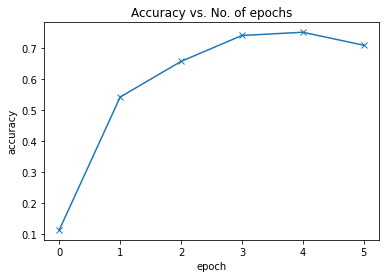

In [44]:
plot_accuracies(history)

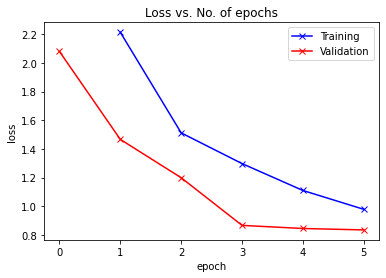

In [45]:
plot_losses(history)

In [46]:
history += fit(5, 0.000001, model, train_dl, valid_dl, torch.optim.Adam)  # Reducing the learning rate and training for 5 more epochs

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.7467, val_loss: 0.9995, val_acc: 0.6875
Epoch [1], train_loss: 0.8128, val_loss: 0.7873, val_acc: 0.8021
Epoch [2], train_loss: 0.7271, val_loss: 0.9034, val_acc: 0.7188
Epoch [3], train_loss: 0.6753, val_loss: 0.9093, val_acc: 0.6979
Epoch [4], train_loss: 0.6627, val_loss: 0.8244, val_acc: 0.7708


## Transfer Learning
* In transfer learning we use the knowledge gained from training other models by applying it to our model.

* We will be using the ResNet34 model pretrained on the ImageNet dataset.

## ImageNet Dataset
* Has about 1 million images(~20GB in size) belonging to about 1000 classes.
* It has been trained for weeks and has been trained to identify a lot of objects.
* The initial layers of this model already contain a lot of information to identify a lot of things.

Example: 
1. The first few layers learn things like line and curves.
2. The second layer learns things like shapes.
3. The 3rd layer identifies patterns like eyes,nose ect.


*  As we get further and further 
The model begins to recognize thing like human faces,type of flowers.

### Here we will just take the final layer of the model which was trained for 1000 or so classes and replace it with 8 classes as we have to classify 8 anime characters.

In [47]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [48]:
model = to_device(ResNet34(len(dataset.classes),pretrained = True),device)  ## pretrained = True since our model is already trained.

In [49]:
model  ## ResNet34 architecture  ## contains 34 layers 


ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

## Normalizing our data according to the ImageNet dataset.

In [50]:
import torchvision.transforms as tt ## Normalizing our model w.r.t the ImageNet dataset

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),tt.RandomCrop(img_size),tt.ToTensor(),tt.Normalize(*imagenet_stats)]))

In [51]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

from torch.utils.data import DataLoader

batch_size = 4  # Setting a batch size

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [52]:
train_dl = DeviceDataLoader(train_dl, device)  ## Reinitialising our data.
valid_dl = DeviceDataLoader(valid_dl, device)

## fit_one_cycle or one cycle learning rate annealing.

Initially takes a low learning rate then increases it by a factor of 10 for about 30% of the iterations and for the rest 70% of the iterations slowly decreases the learning rate down to zero.

In [53]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.0625, 'val_loss': 2.4202070236206055}]

## Training


## Using a couple of regularization techniques.

### 1.Gradient clipping

Gradient clipping is a technique to prevent exploding gradients in very deep networks.

Exploding gradients are a problem where large error gradients accumulate and result in very large updates to neural network model weights during training

### 2. weight decay

Weight Decay, or Regularization, is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the Norm of the weights

Weight is the parameter within a neural network that transforms input data within the network's hidden layers.




In [55]:
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, weight_decay= 0.01,grad_clip = 0.1, opt_func = torch.optim.Adam)

  0%|          | 0/213 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7668, val_loss: 0.6172, val_acc: 0.8229


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7908, val_loss: 0.3832, val_acc: 0.8750


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5540, val_loss: 0.4609, val_acc: 0.8229


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3870, val_loss: 0.3463, val_acc: 0.8854


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2551, val_loss: 0.3112, val_acc: 0.8750


In [56]:
#history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, weight_decay= 0.01,grad_clip = 0.1, opt_func = torch.optim.Adam)

In [57]:
history += fit_one_cycle(5, 0.00001, model, train_dl, valid_dl, weight_decay= 0.01,grad_clip = 0.1, opt_func = torch.optim.Adam)

  0%|          | 0/213 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2230, val_loss: 0.3733, val_acc: 0.8750


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2212, val_loss: 0.3190, val_acc: 0.8750


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2100, val_loss: 0.2874, val_acc: 0.8750


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1920, val_loss: 0.2546, val_acc: 0.9062


  0%|          | 0/213 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1814, val_loss: 0.3414, val_acc: 0.8958


## Current model has about 90 percent accuracy on the validation dataset.

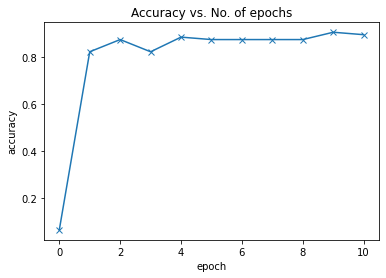

In [58]:
plot_accuracies(history)

Saving the model for webapp

In [68]:
torch.save(model.state_dict(), 'final_maybe.pth')